In [1]:
"""
SAM_pred.pyで出力したマスク画像と元画像を重ね合わせて可視化するスクリプト
"""
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# パス設定（SAM_pred.pyのmain()で使用されているパスに合わせる）
input_dir = Path("../../Sandbox/SAM_Test/img")
mask_dir = Path("../../Sandbox/SAM_Test/mask")
output_overlay_dir = Path("../../Sandbox/SAM_Test/overlay")

# 出力ディレクトリを作成
output_overlay_dir.mkdir(parents=True, exist_ok=True)

print(f"入力画像ディレクトリ: {input_dir}")
print(f"マスクディレクトリ: {mask_dir}")
print(f"重ね合わせ画像出力ディレクトリ: {output_overlay_dir}")


入力画像ディレクトリ: ../../Sandbox/SAM_Test/img
マスクディレクトリ: ../../Sandbox/SAM_Test/mask
重ね合わせ画像出力ディレクトリ: ../../Sandbox/SAM_Test/overlay


In [3]:
def overlay_mask_on_image(image: np.ndarray, mask: np.ndarray, color: tuple = (255, 0, 0), alpha: float = 0.5) -> np.ndarray:
    """
    画像にマスクを色付きで重ね合わせる
    
    Args:
        image: 元画像 (H, W, 3) のRGB画像、uint8
        mask: マスク画像 (H, W) の2値マスク、0/255または0/1
        color: マスクの色 (R, G, B)、デフォルトは赤
        alpha: マスクの透明度（0.0-1.0）
    
    Returns:
        重ね合わせた画像 (H, W, 3) のRGB画像、uint8
    """
    # マスクを0/1の2値に正規化
    if mask.max() > 1:
        mask_binary = (mask > 127).astype(np.float32)
    else:
        mask_binary = mask.astype(np.float32)
    
    # 画像をfloatに変換
    image_float = image.astype(np.float32)
    
    # マスク用の色画像を作成
    color_image = np.zeros_like(image_float)
    color_image[:, :, 0] = color[0]  # R
    color_image[:, :, 1] = color[1]  # G
    color_image[:, :, 2] = color[2]  # B
    
    # マスク領域に色を適用
    mask_3d = mask_binary[:, :, np.newaxis]
    overlay = image_float * (1 - alpha * mask_3d) + color_image * (alpha * mask_3d)
    
    return overlay.astype(np.uint8)


処理対象: 1 枚の画像
  処理完了: dog.jpg -> dog_overlay.png


/tmp/ipykernel_1493/805605653.py:68: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1493/805605653.py:68: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1493/805605653.py:68: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1493/805605653.py:68: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1493/805605653.py:68: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1493/805605653.py:68: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1493/805605653.py:68: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu S

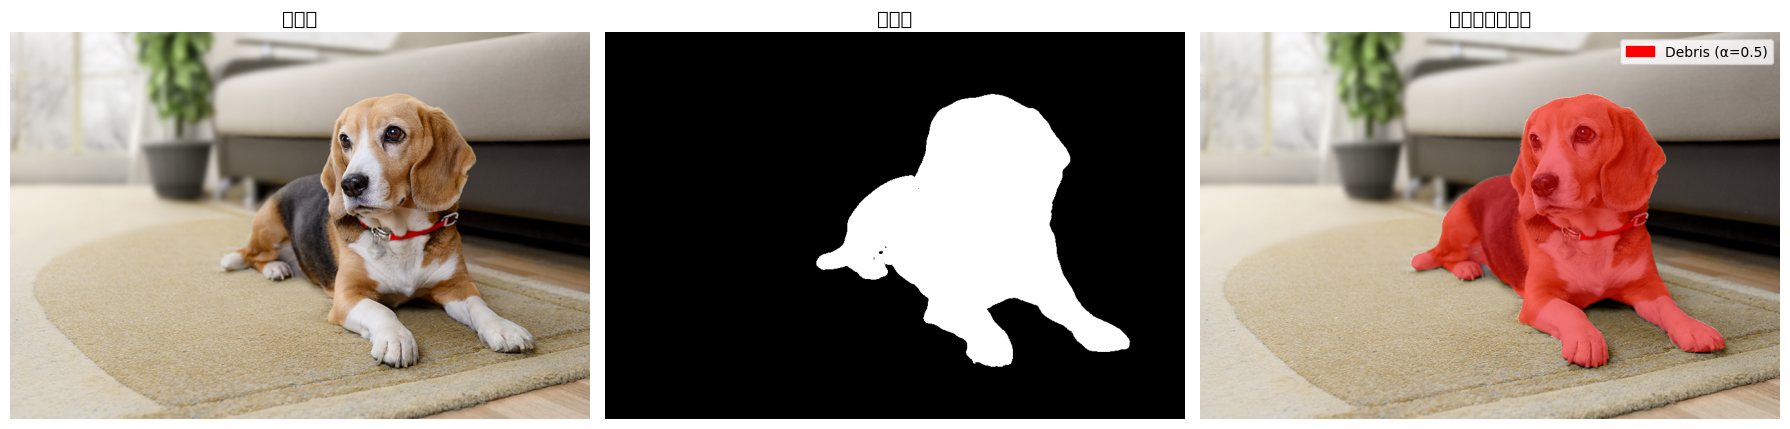


全ての処理が完了しました。
重ね合わせ画像の保存先: ../../Sandbox/SAM_Test/overlay


In [4]:
# 画像ファイルを取得
image_exts = {".jpg", ".jpeg", ".png"}
image_files = sorted(
    [p for p in input_dir.iterdir() if p.is_file() and p.suffix.lower() in image_exts]
)

if not image_files:
    print(f"入力ディレクトリ {input_dir} に対象画像が見つかりませんでした。")
else:
    print(f"処理対象: {len(image_files)} 枚の画像")
    
    # マスクの色設定（見えやすい赤色）
    mask_color = (255, 0, 0)  # 赤色
    mask_alpha = 0.5  # 透明度
    
    for idx, img_path in enumerate(image_files):
        stem = img_path.stem
        mask_path = mask_dir / f"{stem}.png"
        
        # マスクファイルが存在するか確認
        if not mask_path.exists():
            print(f"  スキップ: {img_path.name} に対応するマスクが見つかりません")
            continue
        
        # 画像とマスクを読み込み
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        
        # サイズが一致しているか確認
        if image.shape[:2] != mask.shape:
            print(f"  警告: {img_path.name} の画像とマスクのサイズが一致しません")
            print(f"    画像サイズ: {image.shape[:2]}, マスクサイズ: {mask.shape}")
            continue
        
        # マスクを重ね合わせ
        overlay_image = overlay_mask_on_image(image, mask, color=mask_color, alpha=mask_alpha)
        
        # 重ね合わせ画像を保存
        overlay_path = output_overlay_dir / f"{stem}_overlay.png"
        Image.fromarray(overlay_image).save(overlay_path)
        
        print(f"  処理完了: {img_path.name} -> {overlay_path.name}")
        
        # 1番目の画像をmatplotlibで可視化
        if idx == 0:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # 元画像
            axes[0].imshow(image)
            axes[0].set_title("元画像", fontsize=14)
            axes[0].axis("off")
            
            # マスク画像
            axes[1].imshow(mask, cmap="gray")
            axes[1].set_title("マスク", fontsize=14)
            axes[1].axis("off")
            
            # 重ね合わせ画像
            axes[2].imshow(overlay_image)
            axes[2].set_title("重ね合わせ画像", fontsize=14)
            axes[2].axis("off")
            
            # 凡例を追加
            legend_patch = mpatches.Patch(color=[c/255.0 for c in mask_color], 
                                         label=f'Debris (α={mask_alpha})')
            axes[2].legend(handles=[legend_patch], loc='upper right')
            
            plt.tight_layout()
            plt.savefig(output_overlay_dir / f"{stem}_visualization.png", dpi=150, bbox_inches='tight')
            plt.show()
    
    print(f"\n全ての処理が完了しました。")
    print(f"重ね合わせ画像の保存先: {output_overlay_dir}")
